# PwC Technical Assessment

### Imports

In [93]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### View Files

In [2]:
# Function to read data as dictionaries
def parse(path):
    g = gzip.open(path, 'r')

    for line in g:
        yield eval(line)

In [4]:
steam_reviews_data = []

for data in parse('Data/steam_reviews.json.gz'):
    steam_reviews_data.append(data)

steam_reviews = pd.DataFrame(steam_reviews_data)

### Data Exploration

In [5]:
display(steam_reviews)

username   hours  products product_id  page_order        date  \
0           Chaos Syren     0.1      41.0     725280           0  2017-12-17   
1            ₮ʜᴇ Wᴀʀᴛᴏɴ    51.1     769.0     328100           0  2017-12-27   
2               hello?<    14.6       2.0     328100           1  2017-10-16   
3           Cyderine916     5.0      64.0      35140           0  2018-01-04   
4        DarklyThinking    16.6     577.0      35140           1  2018-01-04   
...                 ...     ...       ...        ...         ...         ...   
7793064        Wildman_   174.3     208.0     252490           5  2013-12-11   
7793065           Stony  1215.2      73.0     252490           6  2013-12-11   
7793066      Deez Knees    50.5     288.0     252490           7  2013-12-11   
7793067          Vidaar   783.5     353.0     252490           8  2013-12-11   
7793068          Zaithe  1000.1     593.0     252490           9  2013-12-11   

                                                      text  early_access  \
0        This would not be acceptable as an entertainme...         False   
1                               looks like a facebook game         False   
2                                    Better than Minecraft         False   
3        I love and idolized Batman and this game is Ma...         False   
4        Still worth playing in 2018.\nProbably my favo...         False   
...                                                    ...           ...   
7793064  A really fun game. There's always something to...          True   
7793065              really fun and addictive game to play          True   
7793066                        gr8 game 10/10 wud buy agen          True   
7793067  Summary: Rust is a survival game created by Fa...          True   
7793068  Best game i've played in awhile. Has some very...          True   

          page  found_funny               compensation            user_id  
0            1          NaN                        NaN                NaN  
1            1          NaN                        NaN                NaN  
2            1          2.0  Product received for free                NaN  
3            1          NaN                        NaN                NaN  
4            1          NaN                        NaN  76561198007483075  
...        ...          ...                        ...                ...  
7793064  10221          NaN                        NaN                NaN  
7793065  10221          NaN                        NaN  76561198089897928  
7793066  10221          NaN                        NaN  76561198048207033  
7793067  10221          NaN                        NaN                NaN  
7793068  10221          NaN                        NaN                NaN  

[7793069 rows x 12 columns]

In [6]:
num_unique_games = steam_reviews['product_id'].nunique()
print(f"Number of unique games: {num_unique_games}")

Number of unique games: 15474


<Axes: xlabel='product_id'>

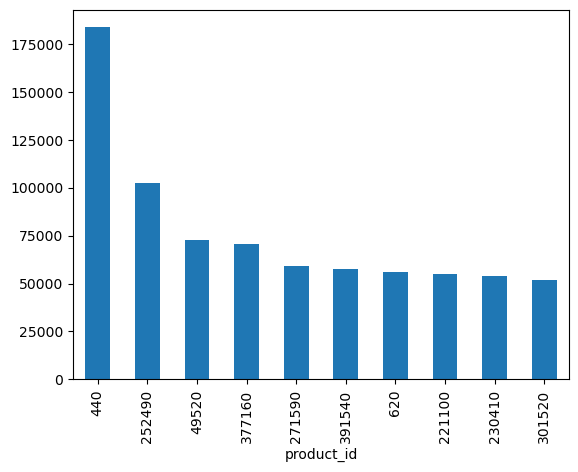

In [7]:
# Top 10 games with most reviews
reviews_per_game = steam_reviews['product_id'].value_counts().head(10)
reviews_per_game.plot.bar()

In [8]:
# Categorise number of hours played for visualisation

def hours_played(df):

    if df['hours'] < 2:
        return '< 2 hours'
    
    elif (df['hours'] >= 2) and (df['hours'] < 10):
        return '2 hours <= x < 10 hours'
    
    elif (df['hours'] >= 10) and (df['hours'] < 50):
        return '10 hours <= x < 50 hours'
    
    elif (df['hours'] >= 50) and (df['hours'] < 100):
        return '50 hours <= x < 100 hours'
    
    elif (df['hours'] >= 100) and (df['hours'] < 500):
        return '100 hours <= x < 500 hours'
    
    else:
        return '> 500 hours'
    
steam_reviews['hours_played'] = steam_reviews.apply(hours_played, axis = 1)

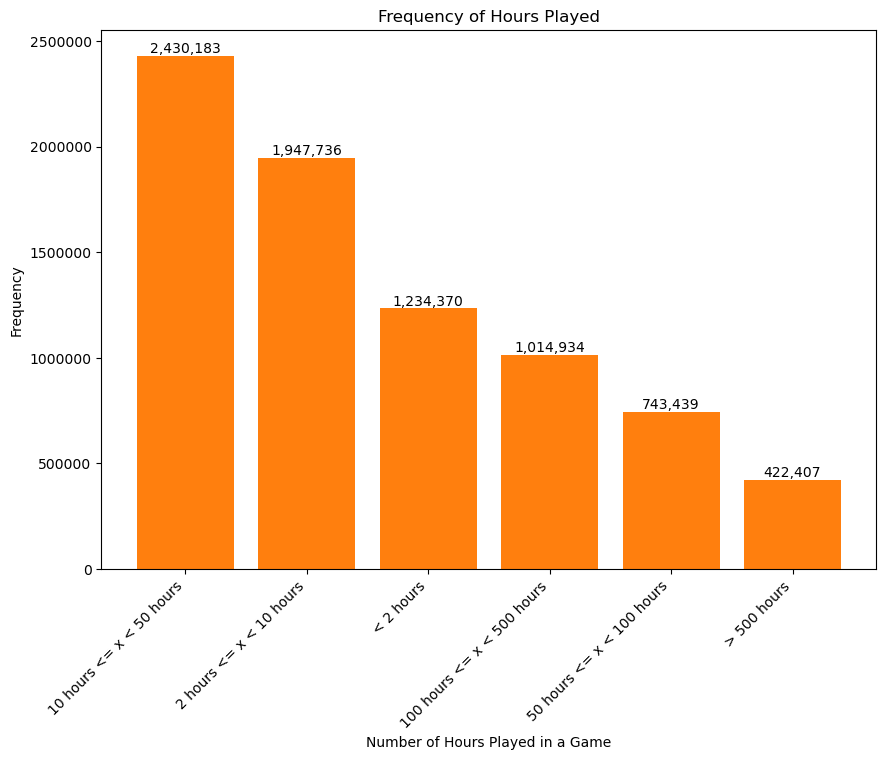

In [9]:
# View hours played data

reviews_per_hours = steam_reviews['hours_played'].value_counts()
fig = plt.figure(figsize = (10, 7))
ax = plt.gca()
ax.ticklabel_format(style='plain')
bar_container = ax.bar(reviews_per_hours.index, reviews_per_hours.values)
ax.set(ylabel = 'Frequency', title = 'Frequency of Hours Played', xlabel = 'Number of Hours Played in a Game')
ax.bar_label(bar_container, fmt = '{:,.0f}')
plt.bar(reviews_per_hours.index, reviews_per_hours.values)
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# Fill found_funny column NaNs with 0

steam_reviews['found_funny'].fillna(0, inplace = True)

In [11]:
# Categorise review as Funny or Not
steam_reviews['num_found_funny'] = steam_reviews['found_funny']
steam_reviews['found_funny'] = np.where(steam_reviews['num_found_funny'] == 0, 'Not Funny', 'Funny')

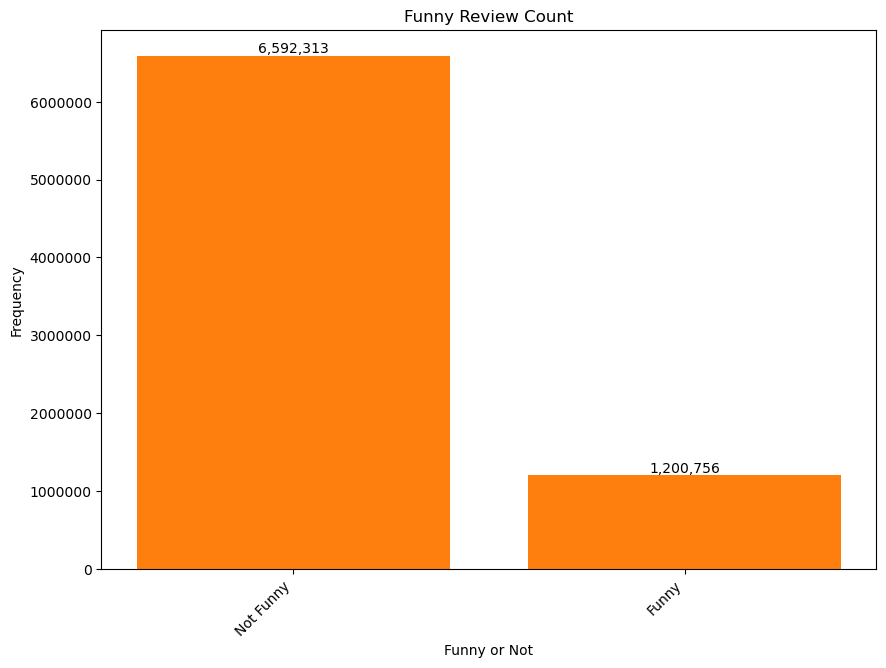

In [12]:
# View funny data

reviews_per_funny = steam_reviews['found_funny'].value_counts()
fig = plt.figure(figsize = (10, 7))
ax = plt.gca()
ax.ticklabel_format(style='plain')
bar_container = ax.bar(reviews_per_funny.index, reviews_per_funny.values)
ax.set(ylabel = 'Frequency', title = 'Funny Review Count', xlabel = 'Funny or Not')
ax.bar_label(bar_container, fmt = '{:,.0f}')
plt.bar(reviews_per_funny.index, reviews_per_funny.values)
plt.xticks(rotation=45, ha='right')
plt.show()

## Machine Learning Use Cases

### Sentiment Analysis

A common application for machine learning with review data is sentiment analysis, which aims to predict whether the overall sentiment of a review is positive or negative.

This is useful for businesses as the average sentiment for a product can be used to measure how well it is received by consumers and thus how well it is selling.

With regards to games, a well-reviewed game might mean more customers are enticed to purchase it, while a poorly-reviewed game may mean the opposite.

Many other business cases follow on from sentiment analysis. These include:

* Advertising well-reviewed games more frequently, allowing for greater visibility and boosting sales.
* Designing of game-bundles or discounts to help sell the poorly reviewed games.
* Identifying customers who frequently review games and rewarding them, boosting engagement.
* Identifying customers who consistently review games with a sentiment that matches the average sentiment of a game, making their reviews more reliable and useful for data analysis.

### Translation and Censoring

Language models can be used to monitor reviews and transform them in a number of ways that can improve user experience.

Models can translate reviews into multiple languages automatically, making these reviews more accessible to a wider audience.

Language models can also be used to check for rude or hurtful language that might reduce engagement on a platform. These models can cencor hamrful language and automatically recommend users to be banned from using a website.

### Boost Engagement

Another application of machine learning with reviews is the identification of helpful or engaging reviews.

Reviews that are helpful or funny could be made visible to more users, possibly boosting engagement on the website and with the game.

This is the use case I have explored below.

## Can a ML model predict whether a review will be funny based on the content of the review?

### Data Preparation

In [13]:
display(steam_reviews)

username   hours  products product_id  page_order        date  \
0           Chaos Syren     0.1      41.0     725280           0  2017-12-17   
1            ₮ʜᴇ Wᴀʀᴛᴏɴ    51.1     769.0     328100           0  2017-12-27   
2               hello?<    14.6       2.0     328100           1  2017-10-16   
3           Cyderine916     5.0      64.0      35140           0  2018-01-04   
4        DarklyThinking    16.6     577.0      35140           1  2018-01-04   
...                 ...     ...       ...        ...         ...         ...   
7793064        Wildman_   174.3     208.0     252490           5  2013-12-11   
7793065           Stony  1215.2      73.0     252490           6  2013-12-11   
7793066      Deez Knees    50.5     288.0     252490           7  2013-12-11   
7793067          Vidaar   783.5     353.0     252490           8  2013-12-11   
7793068          Zaithe  1000.1     593.0     252490           9  2013-12-11   

                                                      text  early_access  \
0        This would not be acceptable as an entertainme...         False   
1                               looks like a facebook game         False   
2                                    Better than Minecraft         False   
3        I love and idolized Batman and this game is Ma...         False   
4        Still worth playing in 2018.\nProbably my favo...         False   
...                                                    ...           ...   
7793064  A really fun game. There's always something to...          True   
7793065              really fun and addictive game to play          True   
7793066                        gr8 game 10/10 wud buy agen          True   
7793067  Summary: Rust is a survival game created by Fa...          True   
7793068  Best game i've played in awhile. Has some very...          True   

          page found_funny               compensation            user_id  \
0            1   Not Funny                        NaN                NaN   
1            1   Not Funny                        NaN                NaN   
2            1       Funny  Product received for free                NaN   
3            1   Not Funny                        NaN                NaN   
4            1   Not Funny                        NaN  76561198007483075   
...        ...         ...                        ...                ...   
7793064  10221   Not Funny                        NaN                NaN   
7793065  10221   Not Funny                        NaN  76561198089897928   
7793066  10221   Not Funny                        NaN  76561198048207033   
7793067  10221   Not Funny                        NaN                NaN   
7793068  10221   Not Funny                        NaN                NaN   

                       hours_played  num_found_funny  
0                         < 2 hours              0.0  
1         50 hours <= x < 100 hours              0.0  
2          10 hours <= x < 50 hours              2.0  
3           2 hours <= x < 10 hours              0.0  
4          10 hours <= x < 50 hours              0.0  
...                             ...              ...  
7793064  100 hours <= x < 500 hours              0.0  
7793065                 > 500 hours              0.0  
7793066   50 hours <= x < 100 hours              0.0  
7793067                 > 500 hours              0.0  
7793068                 > 500 hours              0.0  

[7793069 rows x 14 columns]

In [97]:
# Dropping all columns except the review text and the categorisation of funny/not funny
# The idea for this model is to predict whether a review will be funny or not
# based solely on the content of the review

steam_reviews_funny = steam_reviews.drop(columns = ['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'early_access', 'page', 'compensation', 'user_id', 'hours_played', 'num_found_funny'])
display(steam_reviews_funny)

text found_funny
0        This would not be acceptable as an entertainme...   Not Funny
1                               looks like a facebook game   Not Funny
2                                    Better than Minecraft       Funny
3        I love and idolized Batman and this game is Ma...   Not Funny
4        Still worth playing in 2018.\nProbably my favo...   Not Funny
...                                                    ...         ...
7793064  A really fun game. There's always something to...   Not Funny
7793065              really fun and addictive game to play   Not Funny
7793066                        gr8 game 10/10 wud buy agen   Not Funny
7793067  Summary: Rust is a survival game created by Fa...   Not Funny
7793068  Best game i've played in awhile. Has some very...   Not Funny

[7793069 rows x 2 columns]

In [98]:
# Transform funny/not funny into 1, 0 for ml

steam_reviews_funny['found_funny_cat'] = np.where(steam_reviews_funny['found_funny'] == 'Funny', 1, 0)
steam_reviews_funny.drop(columns = ['found_funny'], inplace = True)
steam_reviews_funny.rename(columns = {'found_funny_cat': 'found_funny'}, inplace = True)

In [108]:
# From data exploration, there are a lot more unfunny reviews than funny
# We will balance the data to avoid the model becoming biased towards non-funny prediction
# Additionally, reduce size of dataset for demonstration purposes

all_funny_reviews = steam_reviews_funny[steam_reviews_funny['found_funny'] == 1]
all_not_funny_reviews = steam_reviews_funny[steam_reviews_funny['found_funny'] == 0]

selected_funny_reviews = all_funny_reviews[:100000]
selected_not_funny_reviews = all_not_funny_reviews[:100000]

print(f'Number of funny reviews: {len(selected_funny_reviews)}')
print(f'Number of not funny reviews: {len(selected_not_funny_reviews)}')

selected_review_data = pd.concat((selected_funny_reviews, selected_not_funny_reviews))
selected_review_data.reset_index(inplace = True, drop = True)

Number of funny reviews: 100000
Number of not funny reviews: 100000


In [109]:
# Tokenising the reviews
# Breaking the string-form review into lists of words and punction
# This is in preparation for extracting the features from the text

nltk.download('punkt')

selected_review_data['tokenised_text'] = selected_review_data['text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\barna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
# Remove stopwords and punctuation which are not useful for ml purposes

nltk.download('stopwords')
stopwords_english = stopwords.words('english')
punctuation = string.punctuation

def clean_reviews(review_tokens):
    review_clean = []

    for word in review_tokens:

        if (word not in stopwords_english) and (word not in punctuation):
            review_clean.append(word)

    return review_clean

selected_review_data['clean_tokenised_text'] = selected_review_data['tokenised_text'].apply(clean_reviews)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\barna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
# Stemming
# This reduces a word to its stem, and normalises it
# over many different possible forms of the same word
# (e.g. angry, anger, angered)

stemmer = PorterStemmer()

def stem_review(clean_review_tokens):
    review_stemmed = []

    for word in clean_review_tokens:
        stem_word = stemmer.stem(word)
        review_stemmed.append(stem_word)

    return review_stemmed

selected_review_data['stemmed_text'] = selected_review_data['clean_tokenised_text'].apply(stem_review)

In [112]:
# Create a frequency dictionary
# This counts the frequency of each word across all reviews
# with relation to both funny and non-funny reviews

categories = selected_review_data['found_funny'].to_list()
stemmed_reviews_list = selected_review_data['stemmed_text'].to_list()
freqs = {}

for cat, stemmed_review in zip(categories, stemmed_reviews_list):

    for word in stemmed_review:
        pair = (word, cat)
        freqs[pair] = freqs.get(pair, 0) + 1

# At this point I noted that some of the reviews were not in english
# With more time, you could remove or translate reviews into a common language

In [113]:
# Extract features from frequency of funny/non-funny words
# This assigns a value to each review based on how funny/not-funny its words are

def extract_features(df):
    funny_count = 0
    not_funny_count = 0

    for word in df['stemmed_text']:
        funny_count += freqs.get((word, 1), 0)
        not_funny_count += freqs.get((word, 0), 0)

    return pd.Series([funny_count, not_funny_count])

selected_review_data[['funny_count', 'not_funny_count']] = selected_review_data.apply(extract_features, axis = 1)

In [114]:
# Splitting the data into train and test
# Standar split size of 80% train, 20% test

train, test = train_test_split(selected_review_data, test_size = 0.2, random_state = 29, stratify = selected_review_data['found_funny'])


In [115]:
X_train = train[['funny_count', 'not_funny_count']]
X_test = test[['funny_count', 'not_funny_count']]
y_train = train['found_funny']
y_test = test['found_funny']

In [116]:
# Using a simple logistic regression model

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [117]:
y_pred = model.predict(X_test)

In [118]:
print(f'Accuracy of model: {accuracy_score(y_test, y_pred)}')

Accuracy of model: 0.60525


The accuracy of the model is 60.5%. This isn't that much better than random choice (represented by 50% accuracy).

This could be to a number of factors:

* Size of the dataset
* Quality of the text (foreign language or use of slang words)
* Strength of the model (More powerful models may perform better, like XGBoost or Random Forest)
* Humour is subjective, making it hard to predict what people will find funny.